<a href="https://colab.research.google.com/github/Jay-boo/TP_NLP_advanced/blob/main/TP_advanced_AdrienMARQUER_JeanAlainMOREL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Eleves : Adrien MARQUER et Jean-Alain MOREL**

## Table of Contents
* [I. Recuperation des données](#chapter1)
* [II. Préparation des données](#chapter2)
    * [II.A Nettoyage](#section_2_1)
    * [II.B Encoding de chaque séquence de token](#section_2_2)
* [III. Modèle de Base utilisant les celleules LSTM](#chapter3)
    * [III.A Definition+ training](#section_3_1)
    * [III.B Evaluation](#section_3_2)
    * [III.C Prediction sur le dataset de test](#section_3_3)
* [IV.  Bidirectional LSTM + couche CRF](#chapter4)
* [V.  Utilisation embedding BERT](#chapter5)


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformers
!pip install tf2crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import json
import spacy
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from collections import Counter
import transformers
#from utils import read_conll_file


***
# I. Recuperation des données
<a class="anchor" id="chapter1"></a>

In [64]:
trn=read_conll_file("conll03-trn.txt")
tst=read_conll_file("conll03-tst.txt")
val=read_conll_file("conll03-val.txt")

In [71]:
trn

[[('EU', 'NNP', 'B-ORG'),
  ('rejects', 'VBZ', 'O'),
  ('German', 'JJ', 'B-MISC'),
  ('call', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('boycott', 'VB', 'O'),
  ('British', 'JJ', 'B-MISC'),
  ('lamb', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Peter', 'NNP', 'B-PER'), ('Blackburn', 'NNP', 'I-PER')],
 [('BRUSSELS', 'NNP', 'B-LOC'), ('1996-08-22', 'CD', 'O')],
 [('The', 'DT', 'O'),
  ('European', 'NNP', 'B-ORG'),
  ('Commission', 'NNP', 'I-ORG'),
  ('said', 'VBD', 'O'),
  ('on', 'IN', 'O'),
  ('Thursday', 'NNP', 'O'),
  ('it', 'PRP', 'O'),
  ('disagreed', 'VBD', 'O'),
  ('with', 'IN', 'O'),
  ('German', 'JJ', 'B-MISC'),
  ('advice', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('consumers', 'NNS', 'O'),
  ('to', 'TO', 'O'),
  ('shun', 'VB', 'O'),
  ('British', 'JJ', 'B-MISC'),
  ('lamb', 'NN', 'O'),
  ('until', 'IN', 'O'),
  ('scientists', 'NNS', 'O'),
  ('determine', 'VBP', 'O'),
  ('whether', 'IN', 'O'),
  ('mad', 'JJ', 'O'),
  ('cow', 'NN', 'O'),
  ('disease', 'NN', 'O'),
  ('can', 'MD', 'O'),
  ('be', 'VB'

In [ ]:
print(trn[0])
print("----------")
print(trn[1])


[('EU', 'NNP', 'B-ORG'), ('rejects', 'VBZ', 'O'), ('German', 'JJ', 'B-MISC'), ('call', 'NN', 'O'), ('to', 'TO', 'O'), ('boycott', 'VB', 'O'), ('British', 'JJ', 'B-MISC'), ('lamb', 'NN', 'O'), ('.', '.', 'O')]
----------
[('Peter', 'NNP', 'B-PER'), ('Blackburn', 'NNP', 'I-PER')]


Pour chaque token on a son texte , son tag *(Part of speech tag:[Documentation  Part of speech tag](https://web.archive.org/web/20190206204307/https://www.clips.uantwerpen.be/pages/mbsp-tags))* et son etiquette IOB suivit de son type

L'etiquette IOB d'un token indique sa position au seins d'une entité nommée: 
 - "B-" pour beginning
 - "I-" pour intermediate
 - "O-" pour outside

A cette étiquette IOB on ajoute le label de l'entité nommée associé à chaque token : [Voici un lien fourni une liste exhaustive des labels utilisé dans `spaCy`](https://towardsdatascience.com/extend-named-entity-recogniser-ner-to-label-new-entities-with-spacy-339ee5979044)

*MISC(miscellaneous) : correspond aux entité nommées n'appartenant pas aux catégories précises comme PERS, ORG,...*




In [ ]:
print(f"Taille des 3 jeux de données :\ntrain dataset : {len(trn)}\ntest dataset : {len(tst)}\nval dataset : {len(val)}")

Taille des 3 jeux de données :
train dataset : 14041
test dataset : 3453
val dataset : 3250


***

# II. Preparation des données
<a class="anchor" id="chapter2"></a>

## II.A Nettoyage
<a class="anchor" id="section_2_1"></a>

On normalise nos tokens :

- 1. On utilise `lower()`
- 2. On le conserve unique si il est composé d'au moins 2 lettres

In [ ]:
def normalize_doc(doc_tokens_):
    doc_tokens_norm_=[]
    for token in doc_tokens_:
        norm_text=token[0].lower()
        if (len(list(norm_text))>1):
            tuple_to_add=(norm_text,token[1],token[2])
            doc_tokens_norm_.append(tuple_to_add)
    return doc_tokens_norm_

In [ ]:
normalize_doc(trn[3])

[('the', 'DT', 'O'),
 ('european', 'NNP', 'B-ORG'),
 ('commission', 'NNP', 'I-ORG'),
 ('said', 'VBD', 'O'),
 ('on', 'IN', 'O'),
 ('thursday', 'NNP', 'O'),
 ('it', 'PRP', 'O'),
 ('disagreed', 'VBD', 'O'),
 ('with', 'IN', 'O'),
 ('german', 'JJ', 'B-MISC'),
 ('advice', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('consumers', 'NNS', 'O'),
 ('to', 'TO', 'O'),
 ('shun', 'VB', 'O'),
 ('british', 'JJ', 'B-MISC'),
 ('lamb', 'NN', 'O'),
 ('until', 'IN', 'O'),
 ('scientists', 'NNS', 'O'),
 ('determine', 'VBP', 'O'),
 ('whether', 'IN', 'O'),
 ('mad', 'JJ', 'O'),
 ('cow', 'NN', 'O'),
 ('disease', 'NN', 'O'),
 ('can', 'MD', 'O'),
 ('be', 'VB', 'O'),
 ('transmitted', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('sheep', 'NN', 'O')]

In [ ]:
# On applique la normalisation
trn_norm_=[ normalize_doc(doc) for doc in trn]
tst_norm_=[ normalize_doc(doc) for doc in tst]
val_norm_=[ normalize_doc(doc) for doc in val]

## II.B. Encoding de chaque sequence de token 
<a class="anchor" id="section_2_2"></a>

Dans cette partie on va encoder toutes nos séquence de tokens. Pour cela nous allons procéder de la facon suivante:

- On va considerer un vocabulaire de 10000 mots et crrer un mapping permettant de convertir chaque token en valeur numérique.
- Encodage de chaque séquence. On fixe une longueur de séquence maximale : $L$ (toutes les séquences doivent être de même longueur).On tronque les séquences trop longues et utiliser un padding pour les séquences trop courtes. Pour chaque séquence de longueur $L$ on va appliquer notre mapping afin de pouvoir representer une sequence de token dans un tenseur de valeur numérique

Similairement on va encoder les classes des tokens de chaque séquence de la manière suivante: Pour chaque token d'une séquence de longueur $L$ on utilise un one hot encoding sur un vecteur de dimension $N$ : le nombre total d'etiquettes IOB.

Ainsi pour chaque séquence de taille $L$ on a une representation de taille $L \times N$




In [ ]:
flat_list = []
for sublist in trn_norm_:
    for item in sublist:
        flat_list.append(item[0])

In [ ]:
counter_tokens_norm_=Counter(flat_list)
counter_tokens_norm_

Counter({'eu': 24,
         'rejects': 1,
         'german': 101,
         'call': 38,
         'to': 3424,
         'boycott': 5,
         'british': 96,
         'lamb': 3,
         'peter': 31,
         'blackburn': 12,
         'brussels': 33,
         '1996-08-22': 125,
         'the': 8390,
         'european': 94,
         'commission': 67,
         'said': 1849,
         'on': 2092,
         'thursday': 292,
         'it': 762,
         'disagreed': 2,
         'with': 867,
         'advice': 5,
         'consumers': 9,
         'shun': 1,
         'until': 56,
         'scientists': 6,
         'determine': 11,
         'whether': 45,
         'mad': 13,
         'cow': 12,
         'disease': 37,
         'can': 72,
         'be': 525,
         'transmitted': 2,
         'sheep': 14,
         'germany': 144,
         "'s": 1566,
         'representative': 7,
         'union': 74,
         'veterinary': 8,
         'committee': 30,
         'werner': 2,
         'zwingmann': 2

In [ ]:
#-----------
# creation du mapping
top=counter_tokens_norm_.most_common(10000)
mapping={'':0,'<unk>':1}

next_ind=2
for val,count in top:
    if val not in mapping.keys():
        mapping[val]=next_ind
        next_ind+=1


On fixe $L= \text{longeur séquence maximale}$

In [ ]:

L_max=max([len(trn_ind) for trn_ind in trn_norm_])
print(f"L max : {L_max}")

L max : 90


In [ ]:
# np.argmax([len(trn_ind) for trn_ind in trn_norm_])

In [ ]:

def get_doc_seq(doc_tokens_norm_,length_seq=L_max):
  """
  Return the representation of a sequence of token in a L_max long tensor
  """
  seq=[]
  print(doc_tokens_norm_)
  for token in doc_tokens_norm_:
    if token[0] not  in mapping.keys():
      seq.append(mapping["<unk>"])
    else:seq.append(mapping[token[0]])

    if len(seq)==length_seq:
      break
  while len(seq) < length_seq:
    seq.append(mapping[''])
  assert len(seq)==length_seq
  return seq

In [ ]:
flat_list_tags = []
for sublist in trn_norm_:
    for item in sublist:
        flat_list_tags.append(item[2])
N=len(set(flat_list_tags))
print(f"N= {N}")

N= 9


In [ ]:
mapping_tags={}
all_tags=set(flat_list_tags)
next_ind=0
for val in all_tags:
    if val not in mapping_tags.keys():
        mapping_tags[val]=next_ind
        next_ind+=1

In [ ]:
def one_hot_encode_tag(tag):
    """One hot encode a token associated with the IOB tag in a N long sequence : tag"""
    res=np.zeros(len(mapping_tags.keys()))
    res[mapping_tags[tag]]=1
    return res

In [ ]:

def build_ds(list_df):
    """
    Build datset object converting each token sequence in a L long numerical value sequence and represented by a L x N matrix  
    """
    nsamples = len(list_df) # number of documents
    dim = L_max # embedding dimension
    data = np.empty([nsamples, dim], dtype='float32')
    label = np.zeros([nsamples,dim, N], dtype='int32')
    
    for i in range(nsamples):
        seq=get_doc_seq(doc_tokens_norm_=list_df[i])
        data[i]=seq 
        lab=np.zeros([dim,N],dtype='int32')
        counter_bis=0
        for el in list_df[i]:
            tag=el[2]
            one_hot_tag=one_hot_encode_tag(tag)
            lab[counter_bis]=one_hot_tag
            counter_bis+=1
        label[i]=lab
    ds = tf.data.Dataset.from_tensor_slices((data, label))
    return ds
# visualize the dataset and its elements

In [ ]:
trn_ds=build_ds(trn_norm_)
tst_ds=build_ds(tst_norm_)
val_ds=build_ds(val_norm_)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[('voeks', 'NNS', 'B-PER'), ('who', 'WP', 'O'), ('was', 'VBD', 'O'), ('already', 'RB', 'O'), ('on', 'IN', 'O'), ('probation', 'NN', 'O'), ('for', 'IN', 'O'), ('prior', 'JJ', 'O'), ('pig', 'NN', 'O'), ('thefts', 'NNS', 'O'), ('pleaded', 'VBD', 'O'), ('that', 'IN', 'O'), ('he', 'PRP', 'O'), ('was', 'VBD', 'O'), ('trying', 'VBG', 'O'), ('to', 'TO', 'O'), ('pay', 'VB', 'O'), ('bills', 'NNS', 'O'), ('for', 'IN', 'O'), ('his', 'PRP$', 'O'), ('ex-wife', 'NN', 'O'), ('and', 'CC', 'O'), ('children', 'NNS', 'O')]
[('but', 'CC', 'O'), ('the', 'DT', 'O'), ('court', 'NN', 'O'), ('heard', 'VBD', 'O'), ('that', 'IN', 'O'), ('receipts', 'NNS', 'O'), ('showed', 'VBD', 'O'), ('much', 'JJ', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('money', 'NN', 'O'), ('went', 'VBD', 'O'), ('to', 'TO', 'O'), ('dancers', 'NNS', 'O'), ('at', 'IN', 'O'), ('strip', 'NN', 'O'), ('clubs', 'NNS', 'O'), ('where', 'WRB', 'O'), ('he', 'PRP', 'O'), (

In [ ]:
print(trn_ds.element_spec)
for item in trn_ds.take(1):
    print(item)

(TensorSpec(shape=(90,), dtype=tf.float32, name=None), TensorSpec(shape=(90, 9), dtype=tf.int32, name=None))
(<tf.Tensor: shape=(90,), dtype=float32, numpy=
array([9.610e+02, 1.000e+00, 1.820e+02, 6.030e+02, 5.000e+00, 3.900e+03,
       1.930e+02, 5.729e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 

***

# III. Modèle de base avec les cellules LSTM
<a class="anchor" id="chapter3"></a>

## III.A Model definition +  training 
<a class="anchor" id="section_3_1"></a>

In [ ]:
maxlen=L_max
emdn_dim=len(mapping.keys())
lstm_dim=64
ntags=N

ner1 = tf.keras.Sequential()
ner1.add(tf.keras.layers.InputLayer(input_shape=(maxlen, )))
ner1.add(tf.keras.layers.Embedding(input_dim=emdn_dim, output_dim=lstm_dim, mask_zero=True))
ner1.add(tf.keras.layers.LSTM(lstm_dim, return_sequences=True))
ner1.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ntags)))
ner1.add(tf.keras.layers.Activation("softmax"))

In [ ]:

ner1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
ner1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 90, 64)            640128    
                                                                 
 lstm_3 (LSTM)               (None, 90, 64)            33024     
                                                                 
 time_distributed_3 (TimeDis  (None, 90, 9)            585       
 tributed)                                                       
                                                                 
 activation_2 (Activation)   (None, 90, 9)             0         
                                                                 
Total params: 673,737
Trainable params: 673,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:

train_batched= trn_ds.batch(64).prefetch(64).cache()
val_batched=val_ds.batch(64).prefetch(64).cache()
test_batched=tst_ds.batch(64).prefetch(64).cache()

In [ ]:
training_lstm = ner1.fit(train_batched, epochs=10, validation_data=val_batched)

Epoch 1/10
220/220 [==============================] - 28s 113ms/step - loss: 0.1291 - accuracy: 0.7920 - val_loss: 0.1019 - val_accuracy: 0.8036
Epoch 2/10
220/220 [==============================] - 38s 173ms/step - loss: 0.0771 - accuracy: 0.8163 - val_loss: 0.0802 - val_accuracy: 0.8298
Epoch 3/10
220/220 [==============================] - 27s 122ms/step - loss: 0.0634 - accuracy: 0.8419 - val_loss: 0.0711 - val_accuracy: 0.8427
Epoch 4/10
220/220 [==============================] - 35s 159ms/step - loss: 0.0526 - accuracy: 0.8775 - val_loss: 0.0574 - val_accuracy: 0.8915
Epoch 5/10
220/220 [==============================] - 26s 118ms/step - loss: 0.0382 - accuracy: 0.9237 - val_loss: 0.0466 - val_accuracy: 0.9153
Epoch 6/10
220/220 [==============================] - 27s 121ms/step - loss: 0.0278 - accuracy: 0.9446 - val_loss: 0.0415 - val_accuracy: 0.9242
Epoch 7/10
220/220 [==============================] - 26s 120ms/step - loss: 0.0217 - accuracy: 0.9540 - val_loss: 0.0399 - val_ac

## III.B. Evaluation
<a class="anchor" id="section_3_2"></a>

In [ ]:
scores={}

In [ ]:
def plot_accuracy_loss(training_lstm,keys=["accuracy","val_accuracy","loss","val_loss"]):
    fig,axs=plt.subplots(1,2)
    estim_acc = training_lstm.history[keys[0]]
    valid_acc = training_lstm.history[keys[1]]
    estim_loss = training_lstm.history[keys[2]]
    valid_loss = training_lstm.history[keys[3]]
    axs[0].plot(valid_loss,label="validation")
    axs[0].plot(estim_loss,label="training")
    axs[0].set(ylabel='Loss',xlabel="epoch",title="Validation and training loss")
    axs[0].legend()
    axs[1].plot(valid_acc,label="validation")
    axs[1].plot(estim_acc,label="training")
    axs[1].set(ylabel='Accuracy',xlabel="epoch",title="Validation and training Accuracy")
    axs[0].legend()
    axs[1].legend()
    plt.subplots_adjust(wspace=0.5)
    plt.show()


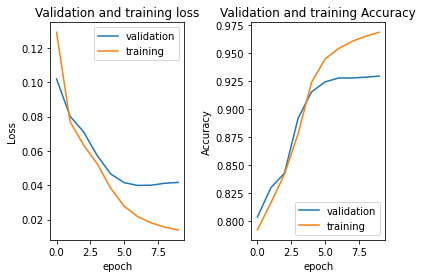

In [ ]:
plot_accuracy_loss(training_lstm=training_lstm)

## III.C Prediction sur le dataset de test
<a class="anchor" id="section_3_3"></a>

In [ ]:
out= ner1.predict(test_batched)

54/54 [==============================] - 5s 48ms/step


In [ ]:
#Converting predictions  into predict tags for each token in the sequences
def convert_prediction_into_tags(out):
    all_predict_tags=[]
    for doc in out:
        new_tags=[]
        for el in range(doc.shape[0]):
            key_=None
            resp=doc[el]
            int_tag=np.argmax(resp)
            for key,val in mapping_tags.items():
                if val==int_tag:
                    key_=key
                    break
            new_tags.append(key_)
        all_predict_tags.append(new_tags)
    return all_predict_tags

In [ ]:
all_predict_tags=convert_prediction_into_tags(out=out)

In [ ]:
ner1.evaluate(test_batched)

54/54 [==============================] - 3s 51ms/step - loss: 0.0470 - accuracy: 0.8999


[0.04696129262447357, 0.8998900651931763]

Nous ne sommes pas sur de la validité eds resultats donner par `evaluate()`: En effet nous ne savons pas si la prediction sur le padding des séquences à été pris en compte ou non!
Nous ne devons pas prendre en compte le padding dans les résultats de nos prédictions

In [ ]:
len(tst_norm_)==len(all_predict_tags)
print("We can see that each sequence have a 90 long prediction")
print(len(tst_norm_[1]),len(all_predict_tags[0]))

We can see that each sequence have a 90 long prediction
2 90


In [ ]:

well_pred=0
counter=0
n_pred=0
for pred_tags,real in zip(all_predict_tags,tst_norm_):
    c=0
    # then in  this case real is the normalize sequence without padding
    for token in real:
        # Looping over real normalize sequence will avoid taking padding in account
        real_val=token[2]
        pred=pred_tags[c]
        c+=1
        n_pred+=1
        if(pred==real_val):
            well_pred+=1
print(f" well pred rate : {well_pred/n_pred}")

 well pred rate : 0.8998900753768844


> On retrouve quasi la même accuracy que après la méthode `evaluate()`

Pour pouvoir mieux analyser les résultats de notre modèle nous allons décomposer notre précision de prédiction selon les différentes étiquettes.

En plsu de la precision nous allons regarder la mesure de rappel:

> *Rmrq : Difference entre rappel et précision*
>
> Exemple:
>
>Precision: Sur les B predit combien sont effectivement B
>
>Rappel : Sur les B effectif combien sont effectivment predit B
 

In [ ]:
def calculate_recall_precision(all_predict_tags,tst_norm_):
    res_by_tags_recall={"B":{"tot":0},"I":{"tot":0},"O":{"tot":0}}
    res_by_tags_prec={"B":{"tot":0},"I":{"tot":0},"O":{"tot":0}}
    sizes_recall={"B":{"tot":0},"I":{"tot":0},"O":{"tot":0}}
    sizes_prec={"B":{"tot":0},"I":{"tot":0},"O":{"tot":0}}

    well_pred=0
    n_pred=0
    for pred_tags,real in zip(all_predict_tags,tst_norm_):
        c=0
        # To avoid padding, we loop over real normalize sequence
        for token in real:
            real_val=token[2]
            pred=pred_tags[c]
            cat_recall=list(real_val)[0]#Real tag of the token
            cat_prec=list(pred)[0]#Predict tag
            sizes_recall[cat_recall]["tot"]+=1
            sizes_prec[cat_prec]["tot"]+=1
            if cat_recall != "O":
                try:
                    sizes_recall[cat_recall][real_val]+=1#Effective real_val category
                except: sizes_recall[cat_recall][real_val]=1
            if cat_prec !="O":
                try:
                    sizes_prec[cat_prec][pred]+=1
                except:sizes_prec[cat_prec][pred]=1
            c+=1
            n_pred+=1
            # Now counting if the prediction is correct
            if(pred==real_val):
                res_by_tags_recall[cat_recall]["tot"]+=1
                res_by_tags_prec[cat_prec]["tot"]+=1
                if cat_recall != "O":
                    try:res_by_tags_recall[cat_recall][real_val]+=1 # One effectif real_val category has been predicted real_val cattegory
                    except:res_by_tags_recall[cat_recall][real_val]=1 
                if cat_prec !="O":
                    try:res_by_tags_prec[cat_prec][pred]+=1
                    except:res_by_tags_prec[cat_prec][pred]=1
                well_pred+=1
            
    overall_prec=well_pred/n_pred
    return res_by_tags_prec,res_by_tags_recall,sizes_prec,sizes_recall,overall_prec

In [ ]:
res_by_tags_prec,res_by_tags_recall,sizes_prec,sizes_recall,overall_prec=calculate_recall_precision(all_predict_tags=all_predict_tags,tst_norm_=tst_norm_)
scores["ner1"]=overall_prec

In [ ]:
def plots_recall_precision(res_by_tags_recall,res_by_tags_prec,sizes_recall,size_prec):
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.4}, sharey=True)

    key_count = 0

    for key, val in sizes_prec.items():
        heights_recall = []
        heights_prec = []
        bars = []

        if key != "O":
            for k, v in val.items():
                res_rec = res_by_tags_recall[key][k] / sizes_recall[key][k]
                res_prec = res_by_tags_prec[key][k] / sizes_prec[key][k]
                heights_recall.append(res_rec)
                heights_prec.append(res_prec)
                if k=="tot":
                    bars.append(f"{key}-{k}")
                else:bars.append(f"{k}")
            y_pos = np.arange(len(bars))
            axes[0, key_count].bar(y_pos, heights_recall)
            axes[1, key_count].bar(y_pos, heights_prec)
            axes[0, key_count].set_xticks(y_pos, bars)
            axes[1, key_count].set_xticks(y_pos, bars)

        key_count += 1

    bars = ["B", "I", "O"]
    y_pos = np.arange(len(bars))
    heights_recall = [res_by_tags_recall[bar]["tot"] / sizes_recall[bar]["tot"] for bar in bars]
    heights_prec = [res_by_tags_prec[bar]["tot"] / sizes_prec[bar]["tot"] for bar in bars]
    axes[0, 2].bar(y_pos, heights_recall)
    axes[0, 2].set_xticks(y_pos, bars)
    axes[1, 2].bar(y_pos, heights_prec)
    axes[1, 2].set_xticks(y_pos, bars)

    plt.show()


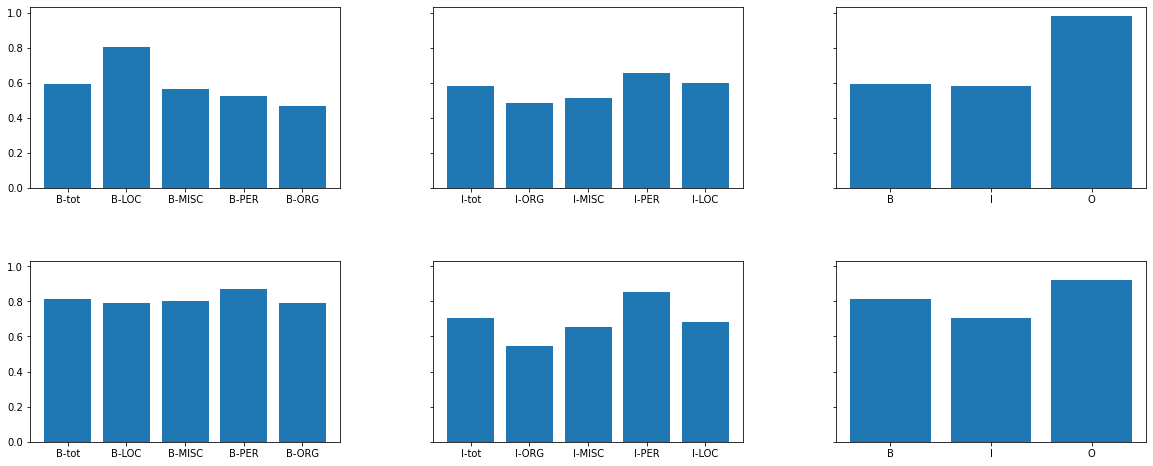

In [ ]:
plots_recall_precision(res_by_tags_recall,
                       res_by_tags_prec,sizes_recall,sizes_prec)

**&rarr; La premiere ligne de plots montre les mesure de recall tandis que la second celle de precision**

On observe que notre modele est performant en ce qui concerne les etiquettes O.

***

# IV. Bidirectional LSTM + Couche CRF
<a class="anchor" id="chapter4"></a>

On essaye dans cette partie d'ameliorer notre modèle de base en changeant l'architecture:

>On introduit une couche LSTM bidirectionnel ainsi qu'une couche CRF en output 

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from tf2crf import CRF, ModelWithCRFLoss

In [ ]:
maxlen=L_max
emdn_dim=len(mapping.keys())
lstm_dim=64
ntags=N

input_=tf.keras.layers.Input(shape=(maxlen, ))
output=tf.keras.layers.Embedding(input_dim=emdn_dim, output_dim=lstm_dim, mask_zero=True) (input_)
output=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True))(output)
output=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ntags))(output)
crf=CRF(units=ntags,dtype='float32')
output = crf(output)

In [ ]:
base_model = Model(input_, output)
model = ModelWithCRFLoss(base_model, sparse_target=False)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:

def build_ds_bis(list_df):
    """returning separated data and response"""
    nsamples = len(list_df) # number of documents
    dim = L_max # embedding dimension
    data = np.empty([nsamples, dim], dtype='float32')
    label = np.zeros([nsamples,dim, N], dtype='int32')
    
    for i in range(nsamples):
        seq=get_doc_seq(doc_tokens_norm_=list_df[i])
        data[i]=seq 
        lab=np.zeros([dim,N],dtype='int32')
        counter_bis=0
        for el in list_df[i]:
            tag=el[2]
            one_hot_tag=one_hot_encode_tag(tag)
            lab[counter_bis]=one_hot_tag
            counter_bis+=1
        label[i]=lab
    return data,label
# visualize the dataset and its elements

In [ ]:
trn_ds_x,trn_ds_y=build_ds_bis(trn_norm_)

[('eu', 'NNP', 'B-ORG'), ('rejects', 'VBZ', 'O'), ('german', 'JJ', 'B-MISC'), ('call', 'NN', 'O'), ('to', 'TO', 'O'), ('boycott', 'VB', 'O'), ('british', 'JJ', 'B-MISC'), ('lamb', 'NN', 'O')]
[('peter', 'NNP', 'B-PER'), ('blackburn', 'NNP', 'I-PER')]
[('brussels', 'NNP', 'B-LOC'), ('1996-08-22', 'CD', 'O')]
[('the', 'DT', 'O'), ('european', 'NNP', 'B-ORG'), ('commission', 'NNP', 'I-ORG'), ('said', 'VBD', 'O'), ('on', 'IN', 'O'), ('thursday', 'NNP', 'O'), ('it', 'PRP', 'O'), ('disagreed', 'VBD', 'O'), ('with', 'IN', 'O'), ('german', 'JJ', 'B-MISC'), ('advice', 'NN', 'O'), ('to', 'TO', 'O'), ('consumers', 'NNS', 'O'), ('to', 'TO', 'O'), ('shun', 'VB', 'O'), ('british', 'JJ', 'B-MISC'), ('lamb', 'NN', 'O'), ('until', 'IN', 'O'), ('scientists', 'NNS', 'O'), ('determine', 'VBP', 'O'), ('whether', 'IN', 'O'), ('mad', 'JJ', 'O'), ('cow', 'NN', 'O'), ('disease', 'NN', 'O'), ('can', 'MD', 'O'), ('be', 'VB', 'O'), ('transmitted', 'VBN', 'O'), ('to', 'TO', 'O'), ('sheep', 'NN', 'O')]
[('germany',

In [ ]:
print(trn_ds_x.shape)# The data of shape (number of sequence,L)
print(trn_ds_y.shape)# SHape (number of sequence , L , N)

(14041, 90)
(14041, 90, 9)


In [ ]:

training_lstm_bis = model.fit(x=trn_ds_x,y=trn_ds_y, epochs=10,batch_size=60,validation_data=val_batched )

Epoch 1/10
235/235 [==============================] - 84s 308ms/step - loss: 9.3314 - accuracy: 0.7779 - val_loss_val: 6.7962 - val_val_accuracy: 0.8337
Epoch 2/10
235/235 [==============================] - 74s 314ms/step - loss: 4.4913 - accuracy: 0.8719 - val_loss_val: 4.6431 - val_val_accuracy: 0.8856
Epoch 3/10
235/235 [==============================] - 65s 276ms/step - loss: 2.7241 - accuracy: 0.9294 - val_loss_val: 3.6371 - val_val_accuracy: 0.9195
Epoch 4/10
235/235 [==============================] - 47s 200ms/step - loss: 1.8391 - accuracy: 0.9529 - val_loss_val: 3.0659 - val_val_accuracy: 0.9330
Epoch 5/10
235/235 [==============================] - 55s 233ms/step - loss: 1.3089 - accuracy: 0.9653 - val_loss_val: 3.0247 - val_val_accuracy: 0.9373
Epoch 6/10
235/235 [==============================] - 70s 300ms/step - loss: 0.9321 - accuracy: 0.9749 - val_loss_val: 2.8138 - val_val_accuracy: 0.9403
Epoch 7/10
235/235 [==============================] - 78s 331ms/step - loss: 0.706

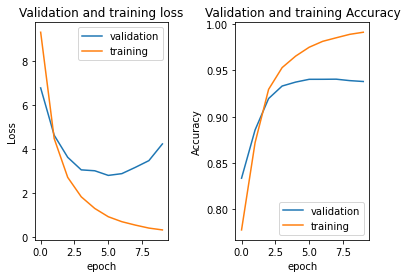

In [ ]:
plot_accuracy_loss(training_lstm_bis,keys=["accuracy","val_val_accuracy","loss","val_loss_val"])

In [ ]:
model.evaluate(test_batched)
out = model.predict(test_batched)

54/54 [==============================] - 7s 63ms/step


In [ ]:
def convert_prediction_into_tags_bis(out):
    all_predict_tags=[]
    for doc in out:
        new_tags=[]
        for el in range(doc.shape[0]):
            key_=None
            resp=doc[el]
            int_tag=resp
            for key,val in mapping_tags.items():
                if val==int_tag:
                    key_=key
                    break
            new_tags.append(key_)
        all_predict_tags.append(new_tags)
    return all_predict_tags

In [ ]:
all_predict_tags=convert_prediction_into_tags_bis(out)
# Can't use the latest convert_prediciton_into_tags() function because now out doesn't contains the differents proba
# But directly the index of the tag for each token

In [ ]:
res_by_tags_prec,res_by_tags_recall,sizes_prec,sizes_recall,overall_prec=calculate_recall_precision(all_predict_tags=all_predict_tags,tst_norm_=tst_norm_)
scores["ner2"]=overall_prec

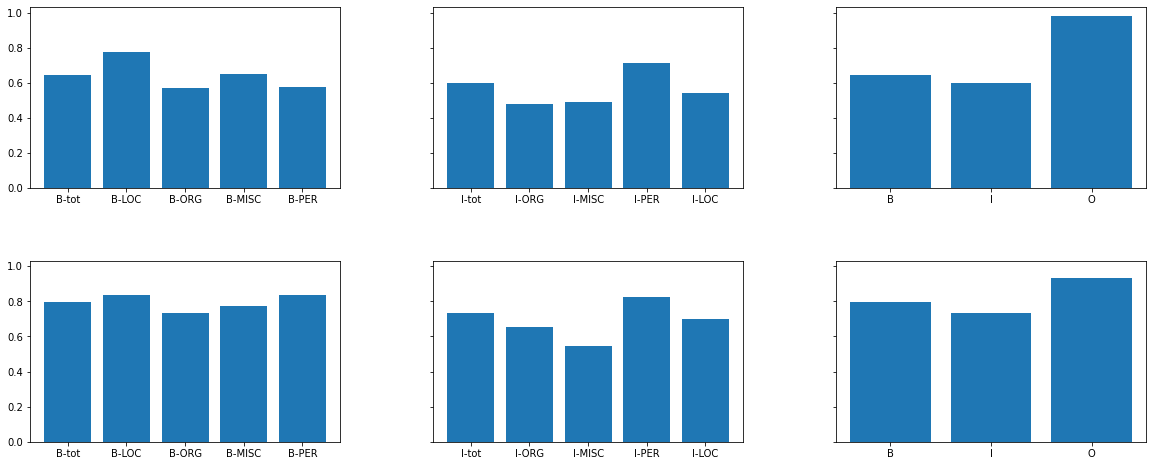

In [ ]:
plots_recall_precision(res_by_tags_recall,
                       res_by_tags_prec,sizes_recall,sizes_prec)


**&rarr; La premiere ligne de plots montre les mesure de recall tandis que la second celle de precision**

On observe une légère amelioration des taux de precision ainsi que les taux de recall pour les groupes B et I 
Ceci s'explique par une augmentation légère mais générales pour chaque sous groupe d'étiquette B-* et I-*

Le groupe d'étiquette O ne semble pas etre impacter par cette nouvelle architecture


***



# V.  Utilisation de la couche d'embedding BERT 
<a class="anchor" id="chapter5"></a>

In [ ]:
from tf2crf import CRF, ModelWithCRFLoss
from tensorflow.keras.models import Model
from transformers import AutoModel, AutoTokenizer 

In [ ]:
bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
maxlen=L_max
ntags=N
emdn_dim = len(mapping.keys())
lstm_dim = 64

In [ ]:
input_ = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32)
bert_layer = bert_model.layers[0]
bert_layer.trainable = False
bert_output = bert_layer(input_)[0]
lstm_layer = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
lstm_output = lstm_layer(bert_output)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ntags))(lstm_output)
output = tf.keras.layers.Activation("softmax")(output)


In [ ]:
bert_embed = tf.keras.Model(inputs=input_, outputs=output)
bert_embed.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
bert_embed.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 90)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             90, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [ ]:
training_ner_bert=bert_embed.fit(train_batched,epochs=10,batch_size=20,validation_data=val_batched)

Epoch 1/10
220/220 [==============================] - 127s 502ms/step - loss: 0.1732 - accuracy: 0.1056 - val_loss: 0.1814 - val_accuracy: 0.1158
Epoch 2/10
220/220 [==============================] - 108s 489ms/step - loss: 0.1633 - accuracy: 0.1063 - val_loss: 0.1807 - val_accuracy: 0.1159
Epoch 3/10
220/220 [==============================] - 108s 490ms/step - loss: 0.1608 - accuracy: 0.1063 - val_loss: 0.1808 - val_accuracy: 0.1160
Epoch 4/10
220/220 [==============================] - 109s 497ms/step - loss: 0.1590 - accuracy: 0.1064 - val_loss: 0.1804 - val_accuracy: 0.1160
Epoch 5/10
220/220 [==============================] - 108s 490ms/step - loss: 0.1586 - accuracy: 0.1064 - val_loss: 0.1805 - val_accuracy: 0.1160
Epoch 6/10
220/220 [==============================] - 107s 489ms/step - loss: 0.1577 - accuracy: 0.1064 - val_loss: 0.1806 - val_accuracy: 0.1160
Epoch 7/10
220/220 [==============================] - 108s 489ms/step - loss: 0.1572 - accuracy: 0.1064 - val_loss: 0.1790 -

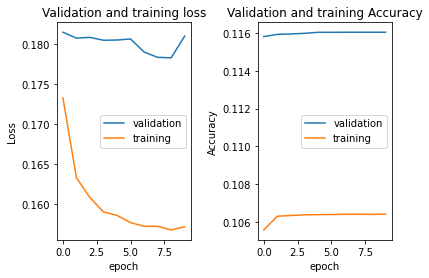

In [ ]:
plot_accuracy_loss(training_lstm=training_ner_bert)

In [ ]:
out=bert_embed.predict(test_batched)

54/54 [==============================] - 23s 370ms/step


In [ ]:
all_predict_tags=convert_prediction_into_tags(out=out)

In [ ]:
bert_embed.evaluate(test_batched)

54/54 [==============================] - 21s 383ms/step - loss: 0.1569 - accuracy: 0.0972


[0.15688776969909668, 0.09721659123897552]

In [ ]:

res_by_tags_prec,res_by_tags_recall,sizes_prec,sizes_recall,overall_prec=calculate_recall_precision(all_predict_tags=all_predict_tags,tst_norm_=tst_norm_)
scores["ner3"]=overall_prec

In [ ]:
overall_prec

0.7907244556113903

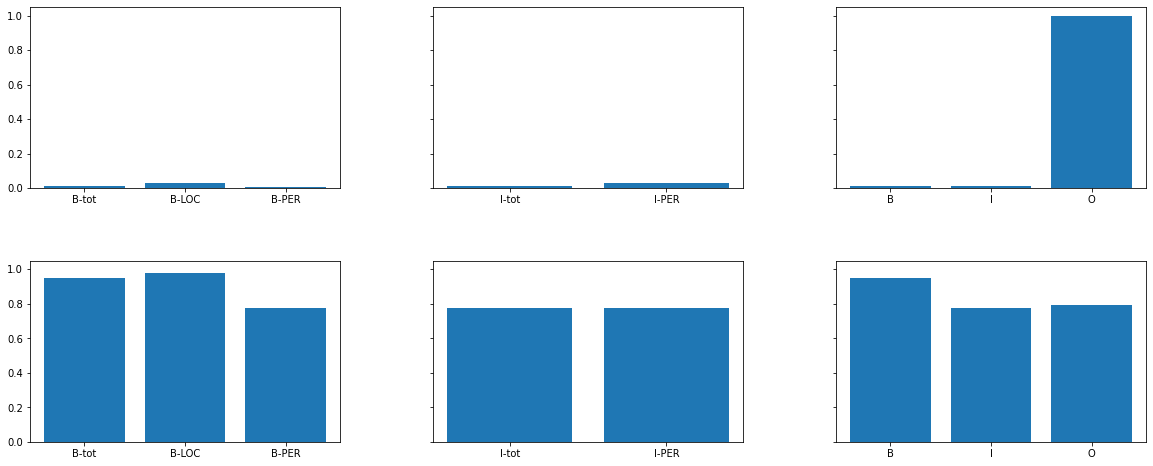

In [ ]:
plots_recall_precision(res_by_tags_recall,
                       res_by_tags_prec,sizes_recall,sizes_prec)

> On obtient de trés mauvais résulats avec la couche d'embedding Bert car celle-ci est inadapté à notre manière d'encoder les tokens (on prédit donc O partout ce qui permet davoir une accuracy = 0.79 en général). Pour pouvoir l'utiliser il aurait fallut utiliser des tokenizer spécifiques.
>



Comparaison des accuracy de nos trois model sur le dataset de test:

In [ ]:
scores

{'ner1': 0.8998900753768844,
 'ner2': 0.9082914572864321,
 'ner3': 0.7907244556113903}